# Portfolio Performance & Risk Analysis (Part II)

## Table of Contents
<hr style="border: 0.25px solid black;">

- [4. Capital Asset Pricing Model](#section-4)
    * [4.1 Market Portfolio and Annualized Covariance](#subsection-41)
    * [4.2 Beta, Systematic Risk, and Idiosyncratic Risk](#subsection-42)
    * [4.3 Rolling Beta](#subsection-43)
    * [4.4 Expected Return and Alpha](#subsection-44)
    * [4.5 Security Market Line](#subsection-45)
$$$$
- [5. Farma-French 5-Factor Model](#section-5)
    * [5.1 Risk Factor Data (Daily)](#subsection-51)
    * [5.2 Linear Regression](#subsection-52)
    * [5.3 Regression Coefficients : Magnitude of Risk Factors Driving Returns](#subsection-53)
    * [5.4 Model Evaluation](#subsection-54)
    * [5.5 Residual Analysis](#subsection-55)

## 4. Capital Asset Pricing Model 
<a id="section-4"></a>
<hr style="border: 0.25px solid black;">

### 4.1 Annualized Covariance
<a id="subsection-41"></a>

$$
\text{Annualized Cov}(\text{Return}_X, \text{Return}_Y) = \left( \frac{1}{T-1} \sum_{t=1}^{T} (\text{Return}_{X,t} - \bar{\text{Return}}_{X}) \times (\text{Return}_{Y,t} - \bar{\text{Return}}_{Y}) \right) \times 252 
$$

In [178]:
ann_cov_mat = returns.cov( ) * 252 
ann_summary = summary["Annual"].copy( )
ann_summary.columns = ["Annual Return", "Annual Volatility", "Annual Sharpe"]

In [179]:
ann_summary 

Annual Return  Annual Volatility  Annual Sharpe
AAPL          0.2979             0.3357         0.8874
AMD           0.4358             0.5363         0.8125
AMZN          0.1956             0.3769         0.5188
AVGO          0.3903             0.3835         1.0178
CRM           0.2036             0.4099         0.4968
GOOGL         0.2405             0.3353         0.7172
INTC          0.0418             0.4125         0.1012
META          0.2479             0.4677         0.5302
MSFT          0.2710             0.3263         0.8306
NFLX          0.2255             0.4867         0.4634
NVDA          0.6798             0.5421         1.2540
ORCL          0.2262             0.3293         0.6869
QCOM          0.2127             0.4222         0.5037
SAP           0.0879             0.3188         0.2757
TSLA          0.7799             0.6808         1.1456
PWP           0.2767             0.3230         0.8568
EWP           0.3024             0.3186         0.9493
MVWP          0.2674             0.3116         0.8584
IVP           0.2662             0.3003         0.8866
KP            0.4755             0.3619         1.3139
MVP           0.1969             0.2829         0.6959
MSP           0.4542             0.3797         1.1962
MP            0.1242             0.2301         0.5399

### 4.2 Beta, Systematic Risk, and Idiosyncratic Risk 
<a id="subsection-42"></a>

$$
\left( \text{Total Risk}_S \right)^2 = \left( \text{Annualized } \sigma_S \right)^2
$$ 

$$
\left( \text{Systematic Risk}_S \right)^2 = \text{Cov}(\text{Return}_{S}, \text{Return}_M) \times 252
$$ 

$$
\left( \text{Unsystematic Risk}_S \right)^2 = \left( \text{Total Risk}_S \right)^2 - \left( \text{Systematic Risk}_S \right)^2
$$ 

$$
\text{Annualized } \beta_S = \frac{\text{Annualized Cov}(\text{Return}_{S}, \text{Return}_M)}{\text{Annualized } \sigma^2_M}
$$

In [180]:
ann_summary["Systematic Risk"] = ann_cov_mat["MP"].apply(np.sqrt) 
ann_summary["Unsystematic Risk"] = (ann_summary["Annual Volatility"] ** 2 - ann_summary["Systematic Risk"] ** 2).apply(np.sqrt) 
ann_summary["Beta"] = ann_cov_mat["MP"].div(ann_cov_mat.loc["MP", "MP"]) 

In [181]:
ann_summary[["Beta", "Systematic Risk", "Unsystematic Risk"]]#.style\
                                                             #.highlight_max(color = "lightgreen")\
                                                             #.highlight_min(color = "lightcoral")  

Beta  Systematic Risk  Unsystematic Risk
AAPL  1.1898           0.2509             0.2230
AMD   1.5151           0.2832             0.4555
AMZN  1.0469           0.2354             0.2944
AVGO  1.2991           0.2622             0.2798
CRM   1.1998           0.2520             0.3233
GOOGL 1.1254           0.2440             0.2300
INTC  1.2037           0.2524             0.3263
META  1.2901           0.2613             0.3879
MSFT  1.1745           0.2493             0.2104
NFLX  1.0146           0.2317             0.4280
NVDA  1.6889           0.2990             0.4522
ORCL  0.9141           0.2200             0.2451
QCOM  1.3163           0.2639             0.3296
SAP   0.9561           0.2249             0.2259
TSLA  1.5180           0.2834             0.6190
PWP   1.2095           0.2530             0.2007
EWP   1.2301           0.2552             0.1907
MVWP  1.1968           0.2517             0.1837
IVP   1.1699           0.2488             0.1681
KP    1.3516           0.2675             0.2438
MVP   1.1063           0.2420             0.1466
MSP   1.3601           0.2683             0.2686
MP    1.0000           0.2301             0.0000

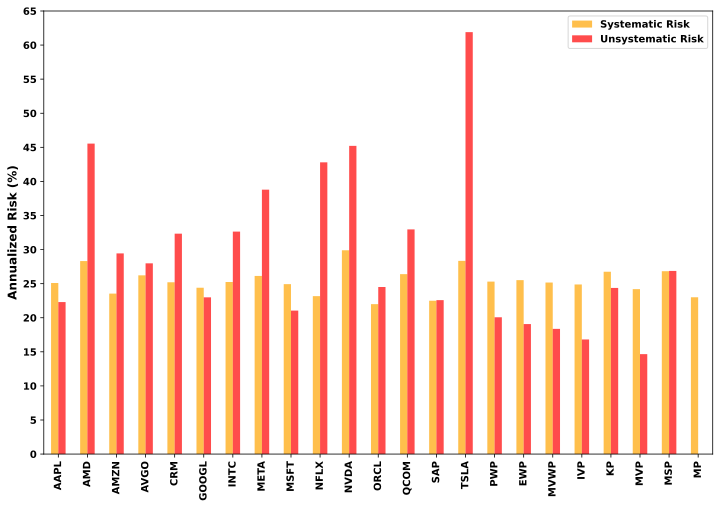

In [182]:
ann_summary[["Systematic Risk", "Unsystematic Risk"]].mul(100).plot(
    kind = "bar", 
    figsize = (12, 8), 
    fontsize = 10, 
    rot = 90, 
    yticks = range(0, 66, 5), 
    color = ["orange", "red"], 
    alpha = 0.7
)  

plt.ylabel("Annualized Risk (%)", fontsize = 12) 
plt.style.use("default")   
plt.show( ) 

### 4.3 Rolling Beta 
<a id="subsection-43"></a>

In [183]:
def plot_rolling_beta(returns_df, window = 3) :
    """
    Arguments :
    ---------
    - returns_df : DataFrame of daily returns 
    - window : int for the interval of the rolling window (months)
    
    Returns :
    -------
    - None 
    
    Function :
    --------
    - Plots the rolling beta for each asset (3-month by default)
    """
    sp500 = yf.download(tickers = "^GSPC", start = start_date, end = end_date)
    sp500_returns = sp500["Close"].pct_change(periods = 1).dropna( )
    sp500_monthly_returns = sp500_returns.resample("BM").agg(lambda daily_ret: (1 + daily_ret).prod( ) - 1)
    
    monthly_returns = returns_df.resample("BM").agg(lambda daily_ret: (1 + daily_ret).prod( ) - 1)
    
    rolling_cov = monthly_returns.rolling(window).cov(sp500_monthly_returns) 
    rolling_var = sp500_monthly_returns.rolling(window).var( )
    rolling_beta = rolling_cov.div(rolling_var, axis = 0) 
    
    assets = returns_df.columns 
    n_assets = len(returns_df.columns)
    
    fig, ax = plt.subplots(nrows = n_assets, ncols = 1, figsize = (12, n_assets * 4)) 
    colors = sns.color_palette("tab20") 
    
    for i in range(n_assets) :
        ax[i].plot(rolling_beta[assets[i]], color = colors[i], label = assets[i])
        ax[i].set_ylabel(ylabel = "Rolling Beta", fontsize = 12)
        ax[i].legend( )
    
    plt.style.use("default") 
    plt.show( )

[*********************100%%**********************]  1 of 1 completed


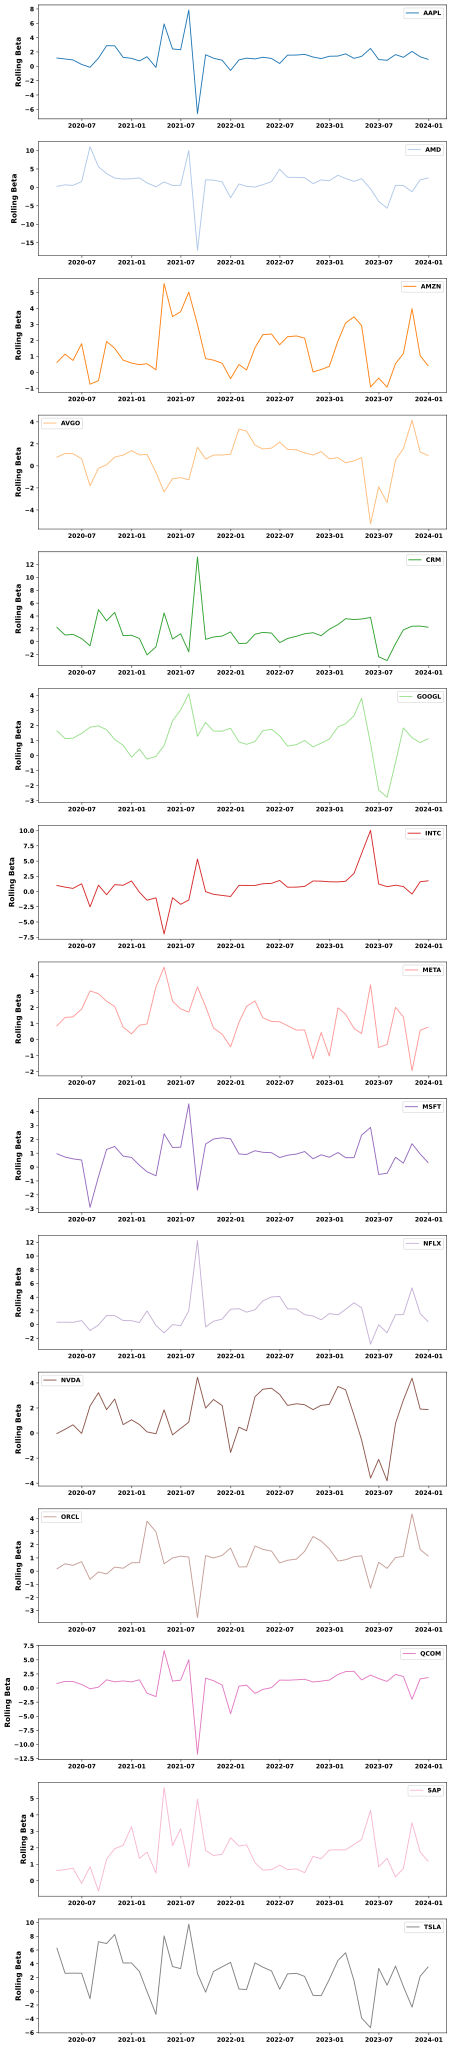

In [184]:
plot_rolling_beta(returns[tickers])

[*********************100%%**********************]  1 of 1 completed


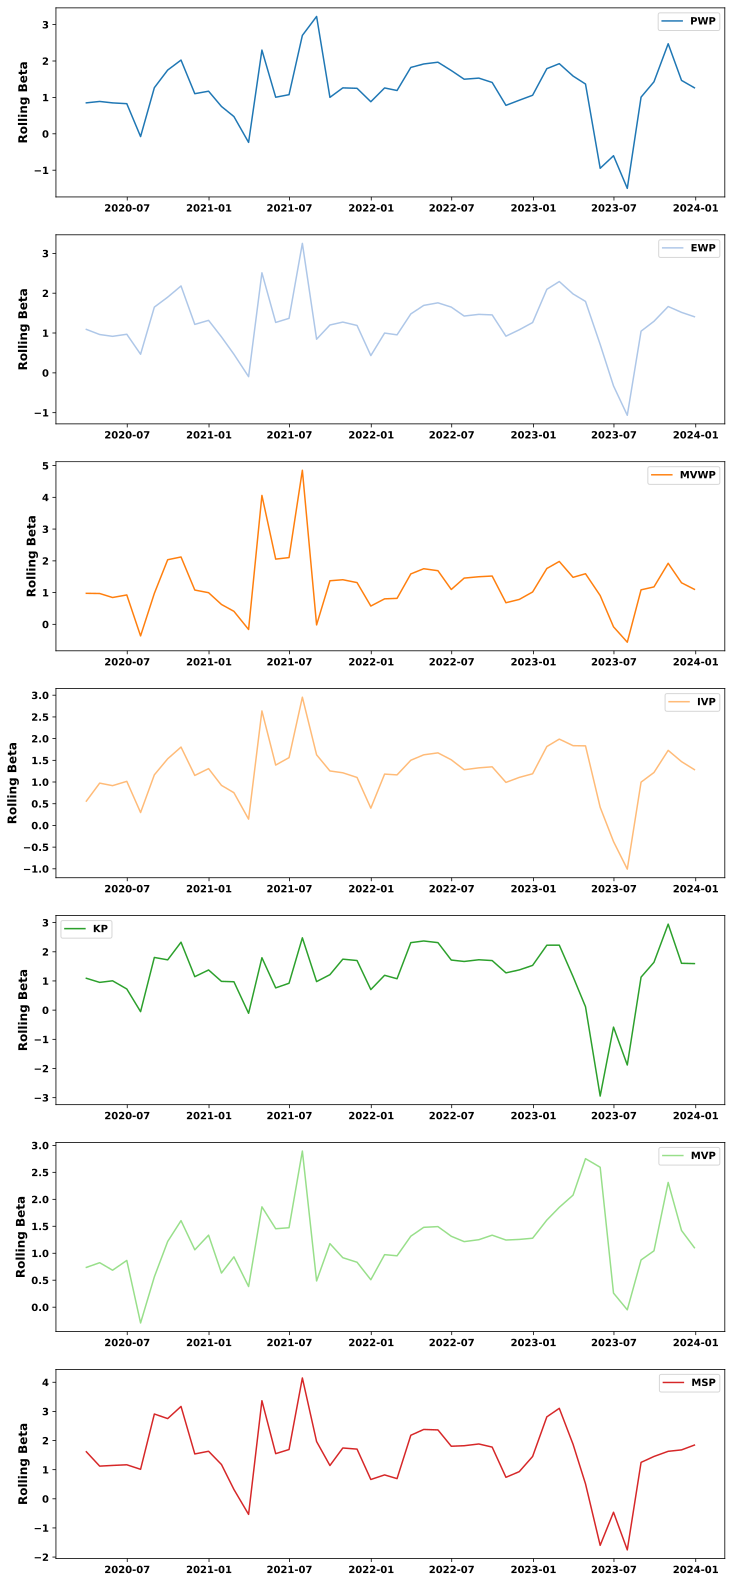

In [185]:
plot_rolling_beta(returns[portfs])

### 4.4 Expected Return and Alpha 
<a id="subsection-44"></a>

$$
\text{Expected Return} = \text{Risk-Free Rate} + \beta \times (\text{Return}_M - \text{Risk-Free Rate})
$$ 

$$
\text{Alpha} = \text{Realized Return} - \text{Expected Return}
$$ 

In [186]:
ann_summary["CAPM Return"] = rf_rate + (ann_summary.loc["MP" , "Annual Return"] - rf_rate) * ann_summary["Beta"] 
ann_summary["Alpha"] = ann_summary["Annual Return"].sub(ann_summary["CAPM Return"])

In [187]:
ann_summary[["Annual Return", "CAPM Return", "Alpha"]]#.style\
                                                      #.highlight_max(color = "lightgreen")\
                                                      #.highlight_min(color = "lightcoral")

Annual Return  CAPM Return   Alpha
AAPL          0.2979       0.1421  0.1558
AMD           0.4358       0.1727  0.2631
AMZN          0.1956       0.1286  0.0670
AVGO          0.3903       0.1524  0.2379
CRM           0.2036       0.1430  0.0606
GOOGL         0.2405       0.1360  0.1045
INTC          0.0418       0.1434 -0.1016
META          0.2479       0.1515  0.0964
MSFT          0.2710       0.1406  0.1303
NFLX          0.2255       0.1256  0.1000
NVDA          0.6798       0.1891  0.4907
ORCL          0.2262       0.1161  0.1101
QCOM          0.2127       0.1540  0.0587
SAP           0.0879       0.1201 -0.0322
TSLA          0.7799       0.1730  0.6070
PWP           0.2767       0.1439  0.1328
EWP           0.3024       0.1459  0.1565
MVWP          0.2674       0.1427  0.1247
IVP           0.2662       0.1402  0.1260
KP            0.4755       0.1573  0.3182
MVP           0.1969       0.1342  0.0627
MSP           0.4542       0.1581  0.2961
MP            0.1242       0.1242  0.0000

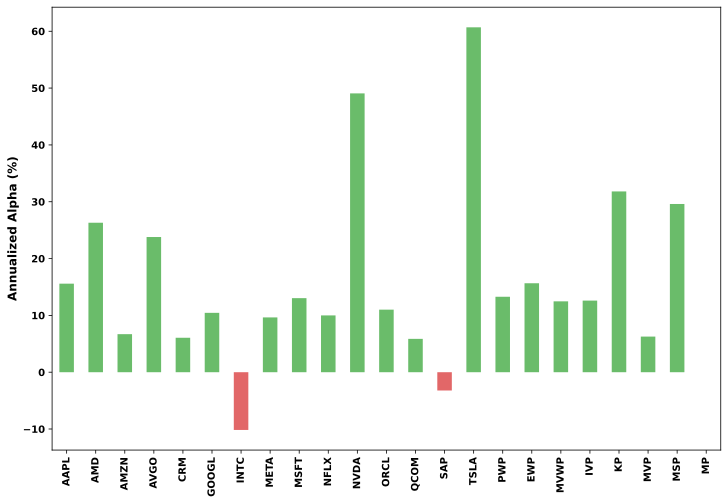

In [188]:
colors = ann_summary["Alpha"].apply(lambda x: "tab:green" if x >= 0 else "tab:red")
ann_summary["Alpha"].mul(100).plot(
    kind = "bar", 
    figsize = (12 , 8), 
    fontsize = 10, 
    rot = 90, 
    color = colors, 
    alpha = 0.7
)

plt.ylabel(ylabel = "Annualized Alpha (%)", fontsize = 12) 
plt.style.use("default")   
plt.show( ) 

### 4.5 Security Market Line 
<a id="subsection-45"></a>

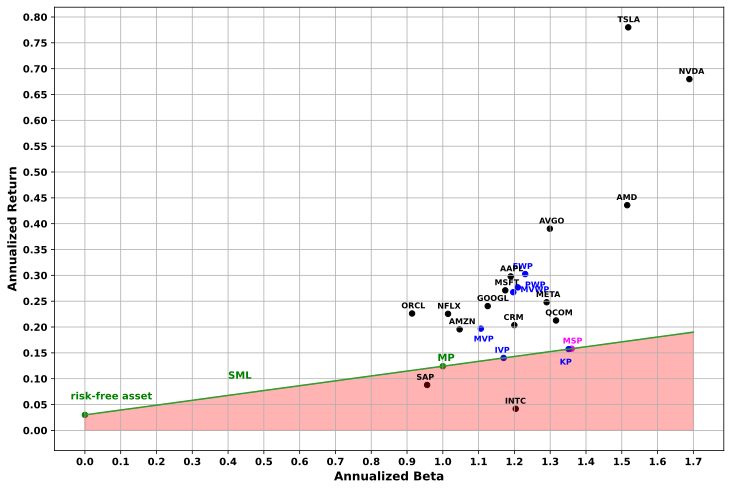

In [189]:
plt.figure(figsize = (12, 8))

# plot the price–weighted portfolio
plt.scatter(
    x = ann_summary.loc["PWP", "Beta"], 
    y = ann_summary.loc["PWP", "Annual Return"], 
    s = 30, 
    c = "blue"
)

plt.annotate(
    "PWP", 
    size = 8, 
    c = "blue", 
    xy = (ann_summary.loc["PWP", "Beta"] + 0.02, ann_summary.loc["PWP", "Annual Return"])
)

# plot the equally–weighted portfolio
plt.scatter(
    x = ann_summary.loc["EWP", "Beta"], 
    y = ann_summary.loc["EWP", "Annual Return"], 
    s = 30, 
    c = "blue"
)

plt.annotate(
    "EWP", 
    size = 8, 
    c = "blue", 
    xy = (ann_summary.loc["EWP", "Beta"] - 0.035, ann_summary.loc["EWP", "Annual Return"] + 0.01)
)

# plot the market-value–weighted portfolio
plt.scatter(
    x = ann_summary.loc["MVWP", "Beta"], 
    y = ann_summary.loc["MVWP", "Annual Return"], 
    s = 30, 
    c = "blue"
)

plt.annotate(
    "MVWP", 
    size = 8, 
    c = "blue", 
    xy = (ann_summary.loc["MVWP", "Beta"] + 0.02, ann_summary.loc["MVWP" , "Annual Return"])
)

# plot the market portfolio
plt.scatter(
    x = ann_summary.loc["MP", "Beta"], 
    y = ann_summary.loc["MP", "Annual Return"], 
    s = 30, 
    c = "green"
)

plt.annotate(
    "MP", 
    size = 10, 
    c = "green", 
    xy = (ann_summary.loc["MP", "Beta"] - 0.015, ann_summary.loc["MP", "Annual Return"] + 0.01)
)

# plot the minimum variance portfolio
plt.scatter(
    x = ann_summary.loc["MVP", "Beta"], 
    y = ann_summary.loc["MVP", "Annual Return"], 
    s = 30, 
    c = "blue"
)

plt.annotate(
    "MVP", 
    size = 8, 
    c = "blue", 
    xy = (ann_summary.loc["MVP", "Beta"] - 0.02, ann_summary.loc["MVP", "Annual Return"] - 0.025)
)

# plot the maximum sharpe portfolio 
plt.scatter(
    x = ann_summary.loc["MSP", "Beta"], 
    y = ann_summary.loc["MSP", "CAPM Return"], 
    s = 30, 
    c = "fuchsia"
)

plt.annotate(
    "MSP", 
    size = 8, 
    c = "fuchsia", 
    xy = (ann_summary.loc["MSP", "Beta"] - 0.025, ann_summary.loc["MSP", "CAPM Return"] + 0.01)
)

# plot the inverse volatility portfolio 
plt.scatter(
    x = ann_summary.loc["IVP", "Beta"], 
    y = ann_summary.loc["IVP", "CAPM Return"], 
    s = 30, 
    c = "blue"
)

plt.annotate(
    "IVP", 
    size = 8, 
    c = "blue", 
    xy = (ann_summary.loc["IVP", "Beta"] - 0.025, ann_summary.loc["IVP", "CAPM Return"] + 0.01)
)

# plot the Kelly criterion portfolio 
plt.scatter(
    x = ann_summary.loc["KP", "Beta"], 
    y = ann_summary.loc["KP", "CAPM Return"], 
    s = 30,
    c = "blue" 
)

plt.annotate(
    "KP", 
    size = 8, 
    c = "blue", 
    xy = (ann_summary.loc["KP", "Beta"] - 0.025, ann_summary.loc["KP", "CAPM Return"] - 0.03)
)

# plot the individual stocks in the portfolio 
plt.scatter(
    x = ann_summary.loc[tickers, "Beta"], 
    y = ann_summary.loc[tickers, "Annual Return"], 
    s = 30, 
    c = "black"
)

for ticker in tickers : 
    plt.annotate(
        ticker, 
        size = 8, 
        xy = (ann_summary.loc[ticker, "Beta"] - 0.03, ann_summary.loc[ticker, "Annual Return"] + 0.01)
    )  

#  plot the risk–free asset and the security market line 
plt.scatter(
    x = pd.Series(data = 0).values, 
    y = rf_rate, 
    s = 30, 
    c = "green"
)

plt.annotate(
    "risk-free asset", 
    size = 10, 
    c = "green", 
    xy = (pd.Series(data = 0).values - 0.04, rf_rate + 0.03)
)

betas = np.array(range(0, 180, 10)) / 100 
capm_returns = rf_rate + (ann_summary.loc["MP", "Annual Return"] - rf_rate) * betas
plt.plot(betas, capm_returns, c = "tab:green")

plt.fill_between(betas, capm_returns, color = "red", alpha = 0.3)
# plt.fill_between(betas, 0.8, color = "green", alpha = 0.4)
plt.annotate("SML", size = 10, c = "green", xy = (0.4, 0.10))

plt.xticks(ticks = np.array(range(0, 18)) / 10)
plt.yticks(ticks = np.array(range(0, 81, 5)) / 100)
plt.xlabel("Annualized Beta",  fontsize = 12)
plt.ylabel("Annualized Return",  fontsize = 12) 
plt.grid( )
plt.style.use("default")  
plt.show( )

## 5. Fama-French 5-Factor Model 
<a id="section-5"></a>
<hr style="border: 0.25px solid black;">

### 5.1 Risk Factor Data (Daily) 
<a id="subsection-51"></a>

- **Market Risk Premium** : Excess Market Return
$$$$
- **Small minus Big** : Size Effect
$$$$
- **High minus Low** : Value Effect
$$$$
- **Robust minus Weak** : Profitability
$$$$
- **Conservative minus Aggressive** : Investment

In [190]:
ff_factors = web.DataReader("F-F_Research_Data_5_Factors_2x3_Daily", "famafrench", start = start_date, end = end_date)[0]
ff_factors = ff_factors.iloc[1: , :-1].copy( )
ff_factors.columns = ["MRP", "SMB", "HML", "RMW", "CMA"]

In [191]:
ff_factors.describe( )

MRP       SMB       HML       RMW       CMA
count 1006.0000 1006.0000 1006.0000 1006.0000 1006.0000
mean     0.0478    0.0012    0.0054    0.0288    0.0096
std      1.4838    0.8327    1.2269    0.6852    0.6008
min    -12.0000   -4.5500   -4.9700   -2.1800   -2.7400
25%     -0.6500   -0.5100   -0.7000   -0.4100   -0.3400
50%      0.0700   -0.0100   -0.0400    0.0100   -0.0100
75%      0.8000    0.4600    0.6975    0.4800    0.3800
max      9.3400    5.7200    6.7300    4.2100    2.5200

### 5.2 Linear Regression 
<a id="subsection-52"></a>

$$
\hat{R}_t = \beta_{0} + \beta_{1} \times (\text{MKT}_t - \text{rf}_t) + \beta_{2} \times \text{SMB}_t + \beta_{3} \times \text{HML}_t + \beta_{4} \times \text{RMW}_t + \beta_{5} \times \text{CMA}_t + \epsilon_{t}
$$

In [192]:
def linear_regression(returns_df, factor_df) :
    """
    Arguments :
    ---------
    - returns_df : DataFrame of returns 
    - factor_df : DataFrame of factor data 
    
    Returns :
    -------
    - pred_returns_df : DataFrame of returns predicted by the model 
    - reg_coefs_df : DataFrame of regression coefficients 
    
    Function :
    --------
    - Fits a linear regression model with factor data as predictor variables and returns as the target variable  
    - Retrieves the regression coefficients of each factor for each asset 
    """
    X = factor_df.copy( )
    Y = returns_df.copy( )
    
    lin_reg = linear_model.LinearRegression(fit_intercept = True)
    lin_reg.fit(X , Y)
    Y_pred = lin_reg.predict(X) 
    
    coefs = lin_reg.coef_
    coefs_columns = [f"Coef_{factor}" for factor in factor_df.columns] 
    
    pred_returns_df = pd.DataFrame(Y_pred, index = returns_df.index, columns = returns_df.columns)
    reg_coefs_df = pd.DataFrame(coefs, index = returns_df.columns, columns = coefs_columns)
    return pred_returns_df, reg_coefs_df

In [193]:
ff_returns = linear_regression(returns[tickers + portfs], ff_factors)[0]

In [194]:
def regression_summary(returns_df, factor_df) :
    """
    Arguments :
    ---------
    - returns_df : DataFrame of returns 
    - factor_df : DataFrame of factor data 
    
    Returns :
    -------
    - None  
    
    Function :
    --------
    - Prints the ANOVA table and summary statistics of the fitted regression model for each asset 
    """
    X = factor_df.to_numpy( )
    X = tools.add_constant(X)
    
    for asset in returns_df.columns :
        Y = returns_df[asset].to_numpy( )
        lin_reg = regression.linear_model.OLS(endog = Y, exog = X).fit( )
        summary = lin_reg.summary( )
        summary.tables[0].title = asset
        print(summary)
        print("")

In [195]:
regression_summary(returns[tickers], ff_factors)

                                     AAPL                                     
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     703.4
Date:                Tue, 24 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:10:30   Log-Likelihood:                 3210.9
No. Observations:                1006   AIC:                            -6410.
Df Residuals:                    1000   BIC:                            -6380.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.245      0.2

In [196]:
regression_summary(returns[portfs], ff_factors)

                                     PWP                                      
Dep. Variable:                      y   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1401.
Date:                Tue, 24 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:10:31   Log-Likelihood:                 3537.6
No. Observations:                1006   AIC:                            -7063.
Df Residuals:                    1000   BIC:                            -7034.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.618      0.0

### 5.3 Regression Coefficients : Magnitude of Risk Factors Driving Returns
<a id="subsection-53"></a>

In [197]:
ff_coefs = linear_regression(returns[tickers + portfs], ff_factors)[1]

In [198]:
def plot_regression_coefs(reg_coefs_df) :
    """
    Arguments :
    ---------
    - reg_coefs_df : DataFrame of regression coefficients of each factor for each asset 
    
    Returns :
    -------
    - None 
    
    Function :
    --------
    - Plots bar charts of the regression coefficients of each factor for each asset 
    """
    reg_coefs_df.mul(100).plot(
        kind = "bar", 
        figsize = (min(12, len(reg_coefs_df.index)), 25), 
        fontsize = 10, 
        width = 0.4, 
        rot = 0, 
        subplots = True, 
        sharex = False, 
        xlabel = "", 
        ylabel = "% Change in Return", 
        alpha = 0.7, 
        legend = False
    ) 

    plt.style.use("default")
    plt.show( )

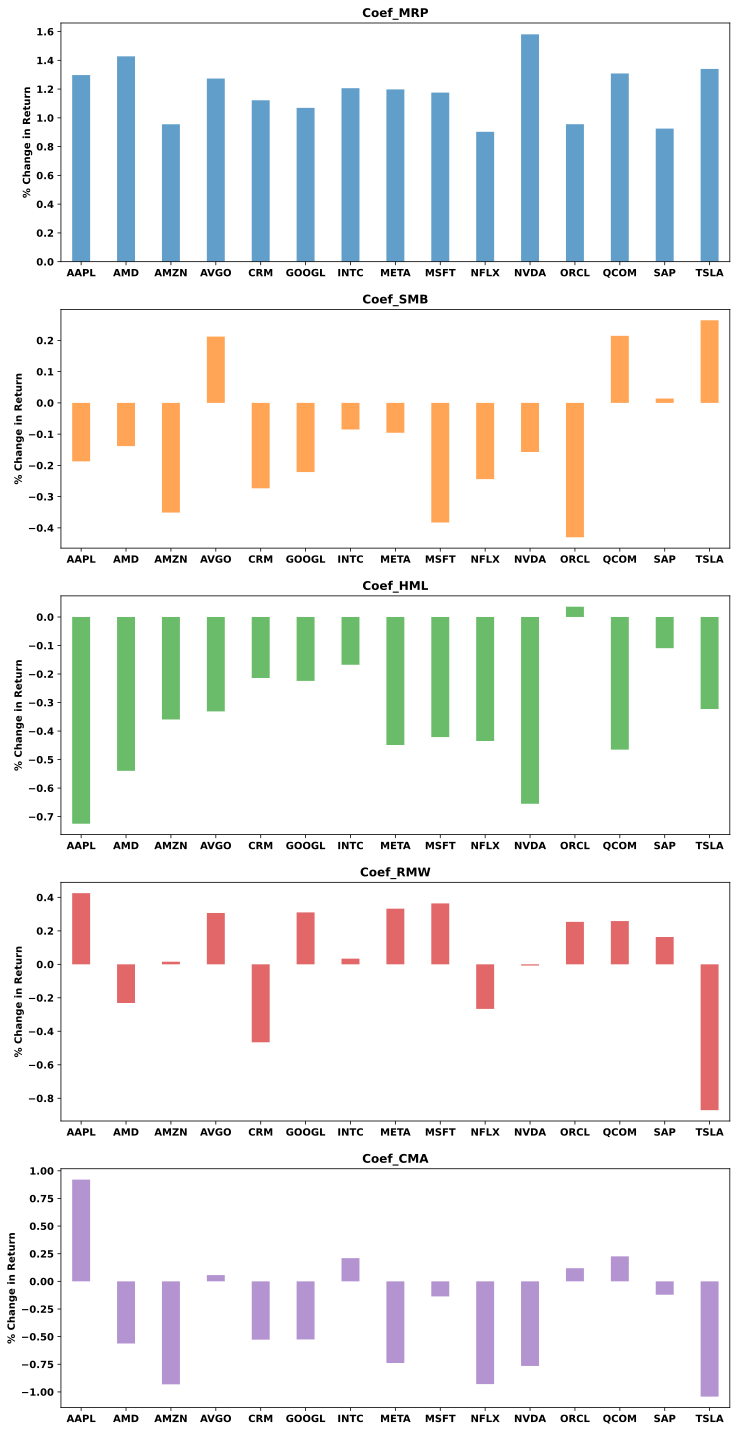

In [199]:
plot_regression_coefs(ff_coefs.loc[tickers])

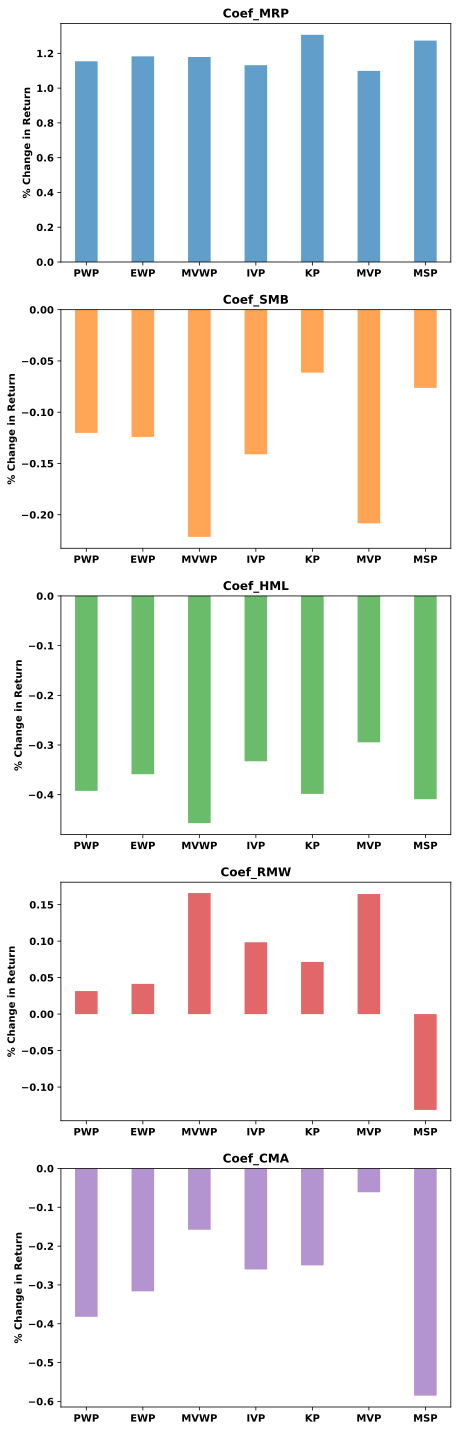

In [200]:
plot_regression_coefs(ff_coefs.loc[portfs])

### 5.4 Model Evaluation 
<a id="subsection-54"></a>

$$
\text{Mean Squared Error} = \frac{1}{T} \sum_{t=1}^{T} (\text{Return}_t - \hat{\text{Return}}_t)^2
$$

$$
\text{Mean Absolute Error} = \frac{1}{T} \sum_{t=1}^{T} |\text{Return}_t - \hat{\text{Return}}_t|
$$

$$ 
\text{Mean Absolute Percentage Error} = \frac{1}{T} \sum_{t=1}^{T} \left| \frac{\text{Return}_t - \hat{\text{Return}}_t}{\text{Return}_t} \right| \times 100
$$

$$
\text{R}^2 = 1 - \frac{{\sum_{t=1}^{T} (\text{Return}_t - \hat{\text{Return}}_t)^2}}{{\sum_{t=1}^{T} (\text{Return}_t - \bar{\text{Return}})^2}}
$$

$$
\text{Adjusted R}^2 = 1 - \frac{{(1 - R^2) \times (T - 1)}}{{T - 5 - 1}}
$$

$$
\text{Akaike Information Criterion} = T \times \log\left(\frac{SSE}{T}\right) + 2 \times 5
$$

$$
\text{Bayesian Information Criterion} = T \times \log\left(\frac{SSE}{T}\right) + 5 \times \log(T)
$$

In [201]:
def eval_perf(Y, Y_pred) :
    """
    Arguments :
    ---------
    - Y : DataFrame of actual daily returns 
    - Y_pred : DataFrame of daily returns predicted by the French-Farma model 
    
    Returns :
    -------
    - perf_df : DataFrame displaying ratios for evaluating a regression model 
    
    Function :
    --------
    - Computes the mean squared error, mean absolute error, mean absolute percentage error, r-squared, adjusted r-squared, akaike information criterion, and bayesian information criterion 
    """
    mse_list = [  ]
    mae_list = [  ]
    mape_list = [  ]
    r2_list = [  ]
    adjusted_r2_list = [  ]
    aic_list = [  ]
    bic_list = [  ]
    for asset in Y.columns :
        
        mse = metrics.mean_squared_error(Y[asset], Y_pred[asset])
        mae = metrics.mean_absolute_error(Y[asset], Y_pred[asset]) 
        mape = metrics.mean_absolute_percentage_error(Y[asset], Y_pred[asset]) 
        r2 = metrics.r2_score(Y[asset], Y_pred[asset])
        adjusted_r2 = 1 - ((1 - r2) * (len(Y) - 1) / (len(Y) - 5 - 1))
        
        residuals = Y[asset] - Y_pred[asset] 
        sse = np.sum(residuals ** 2)
        aic = len(Y[asset]) * np.log(sse / len(Y[asset])) + 2 * 5   
        bic = len(Y[asset]) * np.log(sse / len(Y[asset])) + 5 * np.log(len(Y[asset])) 
        
        mse_list.append(mse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        adjusted_r2_list.append(adjusted_r2)
        aic_list.append(aic)
        bic_list.append(bic)
    
    perf_metrics_df = pd.DataFrame({
        "Mean Squared Error" : mse_list, 
        "Mean Absolute Error" : mae_list, 
        "Mean Absolute Percentage Error" : mape_list, 
        "R-Squared" : r2_list, 
        "Adjusted R-Squared" : adjusted_r2_list, 
        "Akaike Information Criterion" : aic_list, 
        "Bayesian Information Criterion" : bic_list
    }, index = Y.columns) 
    return perf_metrics_df 

In [202]:
ff_model_perf = eval_perf(returns[tickers + portfs], ff_returns)

In [203]:
ff_model_perf

Mean Squared Error  Mean Absolute Error  \
AAPL               0.0001               0.0072   
AMD                0.0005               0.0165   
AMZN               0.0002               0.0103   
AVGO               0.0002               0.0099   
CRM                0.0003               0.0108   
GOOGL              0.0002               0.0083   
INTC               0.0004               0.0124   
META               0.0004               0.0130   
MSFT               0.0001               0.0064   
NFLX               0.0006               0.0147   
NVDA               0.0004               0.0143   
ORCL               0.0002               0.0099   
QCOM               0.0003               0.0121   
SAP                0.0002               0.0096   
TSLA               0.0011               0.0236   
PWP                0.0001               0.0052   
EWP                0.0000               0.0048   
MVWP               0.0000               0.0044   
IVP                0.0000               0.0044   
KP                 0.0001               0.0069   
MVP                0.0000               0.0045   
MSP                0.0001               0.0072   

       Mean Absolute Percentage Error  R-Squared  Adjusted R-Squared  \
AAPL                 74318327308.1408     0.7786              0.7775   
AMD                  30847750226.0051     0.5350              0.5327   
AMZN                 33063299001.7541     0.5983              0.5963   
AVGO                           2.1399     0.6338              0.6320   
CRM                            2.0696     0.5601              0.5579   
GOOGL                10053379473.9496     0.6625              0.6608   
INTC                220595772609.7285     0.4541              0.4514   
META                 29571546721.9661     0.4918              0.4892   
MSFT                 28325652081.1725     0.7944              0.7933   
NFLX                           2.1022     0.3787              0.3756   
NVDA                102378703641.6870     0.6544              0.6526   
ORCL                 24012686330.8341     0.4319              0.4290   
QCOM                           1.6067     0.5505              0.5483   
SAP                  96333195879.7098     0.4829              0.4804   
TSLA                 48682906961.4130     0.3878              0.3848   
PWP                            1.4360     0.8751              0.8744   
EWP                            1.5852     0.9005              0.9000   
MVWP                           1.7111     0.9097              0.9093   
IVP                 647101600745.3192     0.8999              0.8994   
KP                             2.8541     0.8276              0.8267   
MVP                            1.7965     0.8743              0.8737   
MSP                            3.5142     0.8325              0.8317   

       Akaike Information Criterion  Bayesian Information Criterion  
AAPL                     -9266.6691                      -9242.1004  
AMD                      -7577.3232                      -7552.7545  
AMZN                     -8434.3703                      -8409.8016  
AVGO                     -8492.6689                      -8468.1002  
CRM                      -8174.0428                      -8149.4741  
GOOGL                    -8844.6070                      -8820.0384  
INTC                     -7943.9957                      -7919.4270  
META                     -7763.5153                      -7738.9466  
MSFT                     -9398.4096                      -9373.8409  
NFLX                     -7481.3678                      -7456.7991  
NVDA                     -7854.3784                      -7829.8097  
ORCL                     -8357.2893                      -8332.7206  
QCOM                     -8092.8100                      -8068.2413  
SAP                      -8517.4443                      -8492.8756  
TSLA                     -6820.8187                      -6796.2500  
PWP                      -9920.0125                      -9895.4438  
EWP      

In [204]:
def plot_fitted_vs_actual(Y, Y_pred) :
    """
    Arguments :
    ---------
    - Y : DataFrame of actual daily returns 
    - Y_pred : DataFrame of daily returns predicted by French-Farma model 
    
    Returns :
    -------
    - None 
    
    Function :
    --------
    - Plots the ligne graphs of predicted cumulative returns and actual cumulative returns for each asset 
    """
    residuals = Y - Y_pred 
    
    assets = Y.columns
    n_assets = len(assets)
    
    fig , ax = plt.subplots(figsize = (12 , n_assets * 5), sharex = False, sharey = False, nrows = n_assets, ncols = 1)
    colors = sns.color_palette("tab20") 
    
    for i, asset in enumerate(assets) :
            cum_returns_asset = (1 + Y[asset]).cumprod( ) - 1 
            cum_returns_ff = (1 + Y_pred[asset]).cumprod( ) - 1 
        
            ax[i].plot(cum_returns_asset * 100, color = colors[i], label = asset)
            ax[i].plot(cum_returns_ff * 100, color = "black", alpha = 0.7, label = "Fitted")
        
            ax[i].set_ylabel("Cumulative Returns (%)", fontsize = 12)
            ax[i].legend( )
        
    plt.style.use("default")
    plt.show( )

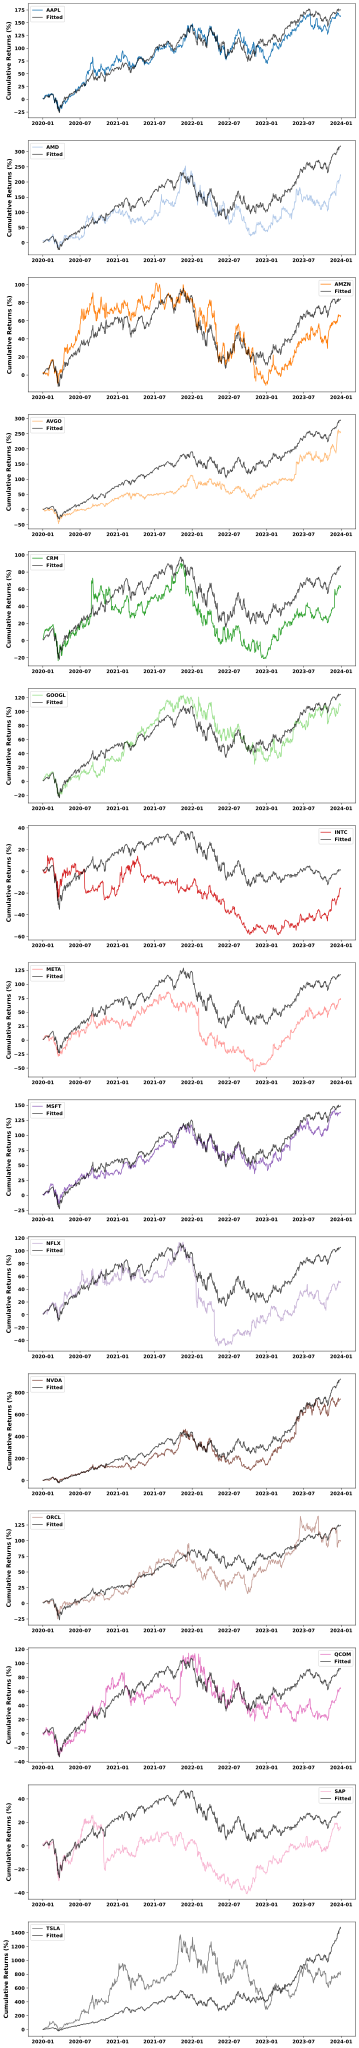

In [205]:
plot_fitted_vs_actual(returns[tickers], ff_returns[tickers])

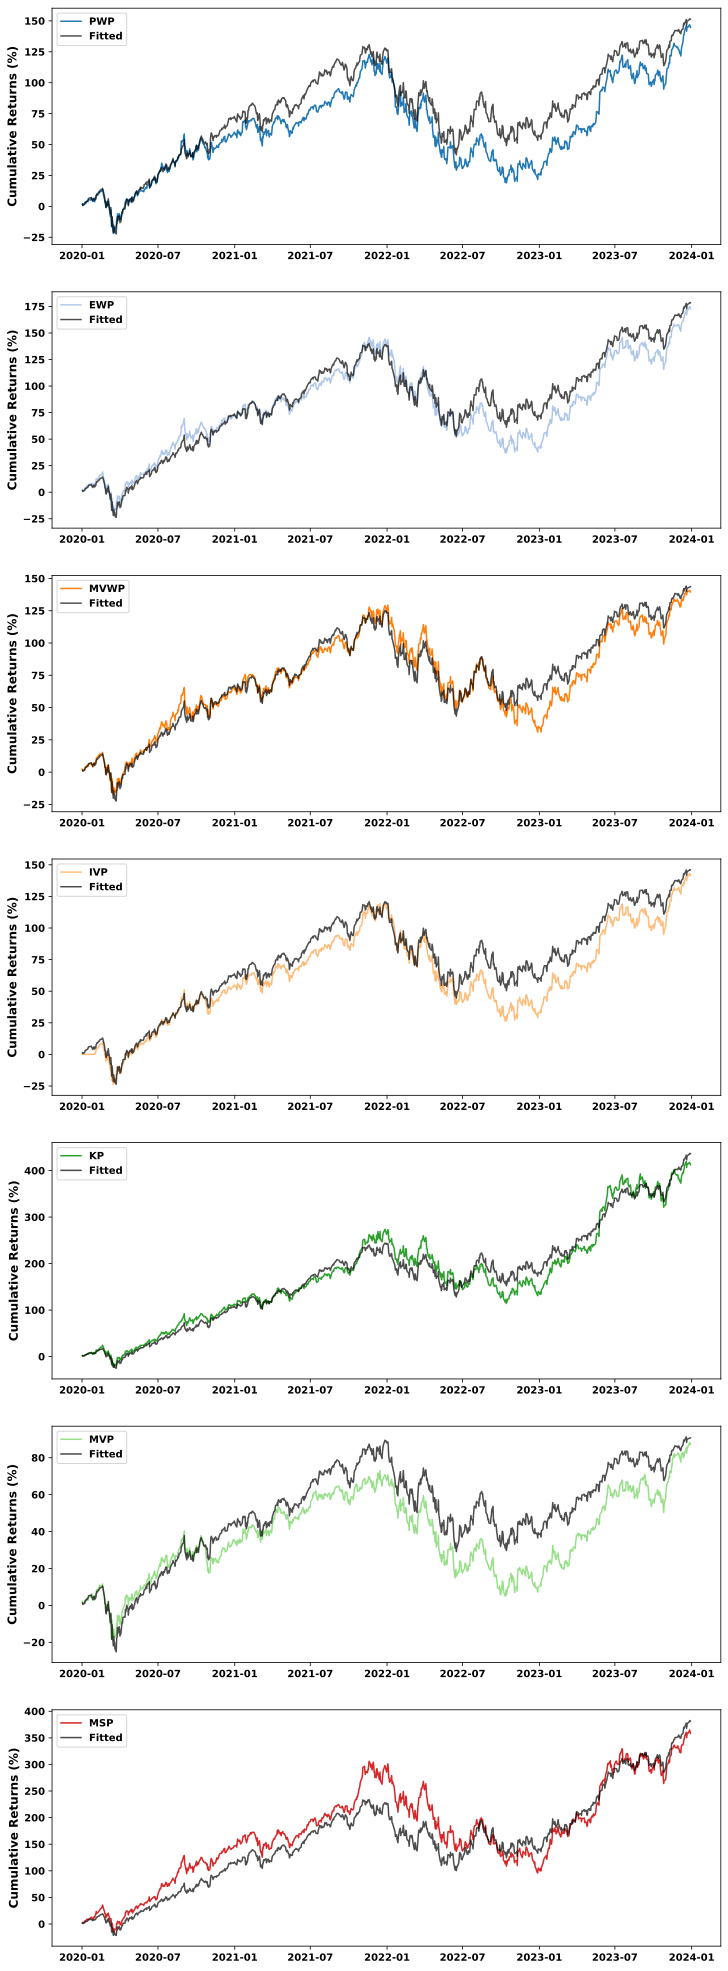

In [206]:
plot_fitted_vs_actual(returns[portfs], ff_returns[portfs])

### 5.5 Residual Analysis 
<a id="subsection-55"></a>

$$
e_t = y_t - \hat{y}_t 
$$ 

$\text{Where :}$
- $ y_t \text{ represents the actual return at time \( t \).} $
- $ \hat{y}_t \text{ represents the predicted return at time \( t \).} $ 

$$
DW = \frac{\sum_{t=2}^{T} (e_t - e_{t-1})^2}{\sum_{t=1}^{T} e_t^2} 
$$

$\text{Where :}$
- $ e_t \text{ represents the residual at time \( t \).} $
- $ T \text{ is the number of periods.} $ 

In [207]:
def residuals_summary(Y, Y_pred) :
    """
    Arguments :
    ---------
    - Y : DataFrame of actual daily returns 
    - Y_pred : DataFrame of daily returns predicted by the regression model 
    
    Returns :
    -------
    - None     
    
    Function :
    --------
     - Computes the difference between actual daily returns and predicted daily returns 
    - Prints the average, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum of residuals 
    """
    residuals = Y - Y_pred 
    summary_df = residuals.mul(100).describe( ).T.drop(columns = "count")
    summary_df.columns = ["Mean", "Standard Deviation", "Minimum", "25th Percentile", "Median", "75th Percentile", "Maximum"]
    summary_df.columns = [f"{col} (%)" for col in summary_df.columns]
    
    print("Summary Statistics of Regression Residuals (%)")
    return summary_df 

In [208]:
residuals_summary(returns[tickers], ff_returns[tickers])

Summary Statistics of Regression Residuals (%)


Mean (%)  Standard Deviation (%)  Minimum (%)  25th Percentile (%)  \
AAPL    -0.0000                  0.9950      -4.0672              -0.5651   
AMD      0.0000                  2.3040      -9.4203              -1.2933   
AMZN     0.0000                  1.5048      -9.5831              -0.8346   
AVGO     0.0000                  1.4618      -9.4840              -0.7658   
CRM      0.0000                  1.7127      -8.7364              -0.7824   
GOOGL   -0.0000                  1.2272      -8.0238              -0.5983   
INTC     0.0000                  1.9201     -15.3034              -0.8195   
META     0.0000                  2.1003     -22.9211              -0.9215   
MSFT    -0.0000                  0.9319      -5.9580              -0.4808   
NFLX    -0.0000                  2.4165     -33.0115              -1.0780   
NVDA     0.0000                  2.0076      -7.7895              -1.2375   
ORCL     0.0000                  1.5636     -13.0034              -0.7275   
QCOM     0.0000                  1.7832     -10.3345              -0.9341   
SAP     -0.0000                  1.4439     -21.4477              -0.7242   
TSLA    -0.0000                  3.3556     -19.0629              -1.7581   

       Median (%)  75th Percentile (%)  Maximum (%)  
AAPL       0.0083               0.5204       7.8163  
AMD       -0.1692               1.1878      17.6648  
AMZN      -0.0883               0.7370      11.3210  
AVGO      -0.0744               0.6917      13.6347  
CRM       -0.0853               0.6895      23.5250  
GOOGL     -0.0415               0.6098       7.5244  
INTC      -0.0112               0.8425      11.1107  
META      -0.0962               0.9517      19.4359  
MSFT      -0.0284               0.4355       7.2819  
NFLX      -0.0945               1.0136      16.5886  
NVDA      -0.0890               0.9857      21.3359  
ORCL      -0.0611               0.6562      14.0708  
QCOM      -0.0584               0.8141      14.9015  
SAP       -0.0219               0.7410       6.0673  
TSLA      -0.2442               1.5646      17.1367

In [209]:
residuals_summary(returns[portfs], ff_returns[portfs])

Summary Statistics of Regression Residuals (%)


Mean (%)  Standard Deviation (%)  Minimum (%)  25th Percentile (%)  \
PWP    -0.0000                  0.7191      -4.3748              -0.4092   
EWP     0.0000                  0.6329      -2.7818              -0.3737   
MVWP    0.0000                  0.5897      -2.5999              -0.3499   
IVP     0.0000                  0.5985      -2.7373              -0.3361   
KP     -0.0000                  0.9466      -3.3383              -0.5231   
MVP     0.0000                  0.6318      -3.1867              -0.3441   
MSP    -0.0000                  0.9789      -4.6671              -0.5328   

      Median (%)  75th Percentile (%)  Maximum (%)  
PWP      -0.0303               0.4028       3.9808  
EWP      -0.0208               0.3799       3.5810  
MVWP     -0.0134               0.3461       2.2770  
IVP      -0.0075               0.3268       3.5342  
KP       -0.0519               0.5370       8.1158  
MVP      -0.0150               0.3325       4.0181  
MSP      -0.0286               0.5513       4.7910

In [210]:
def plot_residuals(Y, Y_pred) :
    """
    Arguments :
    ---------
    - Y : DataFrame of actual daily returns 
    - Y_pred : DataFrame of daily returns predicted by the regression model 
    
    Returns :
    -------
    - None 
    
    Function :
    --------
    - Computes the difference between actual daily returns and predicted daily returns 
    - Plots line graphs of residuals over time for each asset 
    - Plots scatter points for the 10 largest positive residuals and 10 largest negative residuals 
    """
    residuals = Y - Y_pred 
    
    assets = Y.columns
    n_assets = len(assets)
    
    fig , ax = plt.subplots(nrows = n_assets, ncols = 1, figsize = (12, n_assets * 5), sharex = False, sharey = False)
    colors = sns.color_palette("tab20") 
    
    for i, asset in enumerate(assets) :
        ax[i].plot(residuals[asset] * 100, color = colors[i], label = asset)
        dw_statistic = stattools.durbin_watson(residuals[asset])
        legend_label = f"{asset}\nDurbin-Watson Statistic = {dw_statistic:.2f}"
        
        largest_positive_resids = residuals[asset].nlargest(10).sort_index( ) 
        largest_negative_resids = residuals[asset].nsmallest(10).sort_index( ) 
        
        ax[i].scatter(largest_positive_resids.index, largest_positive_resids.values * 100, color = colors[i], s = 30)
        ax[i].scatter(largest_negative_resids.index, largest_negative_resids.values * 100, color = colors[i], s = 30)
        
        ax[i].set_ylabel("Residual (%)", fontsize = 12)
        ax[i].legend([legend_label], fontsize = 10)
    
    plt.style.use("default")
    plt.show( )

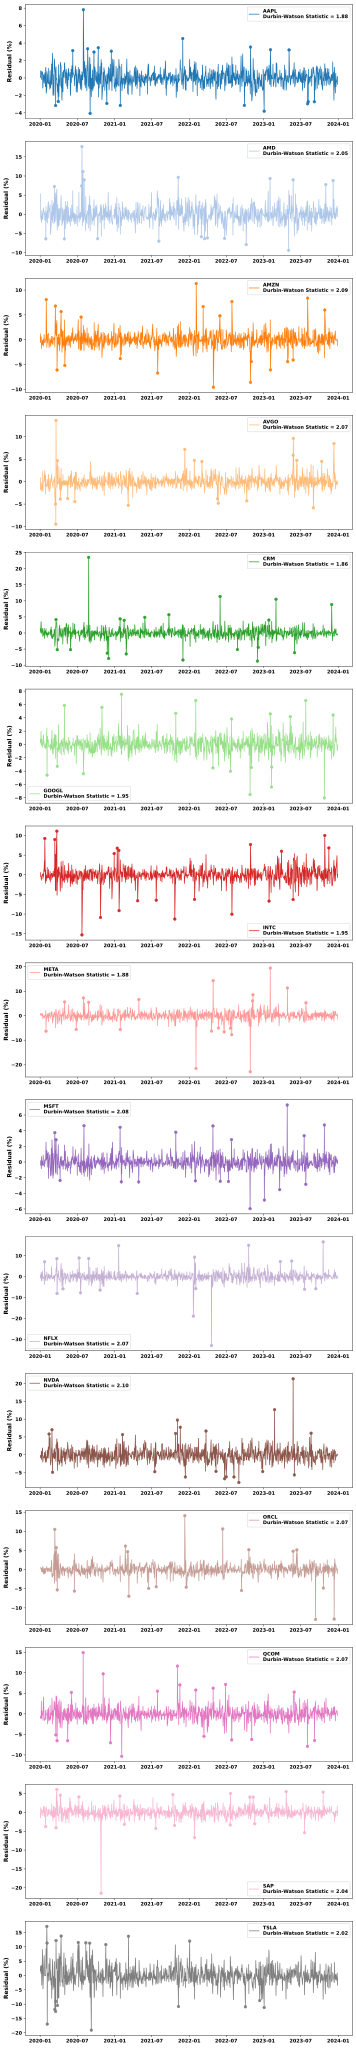

In [211]:
plot_residuals(returns[tickers], ff_returns[tickers])

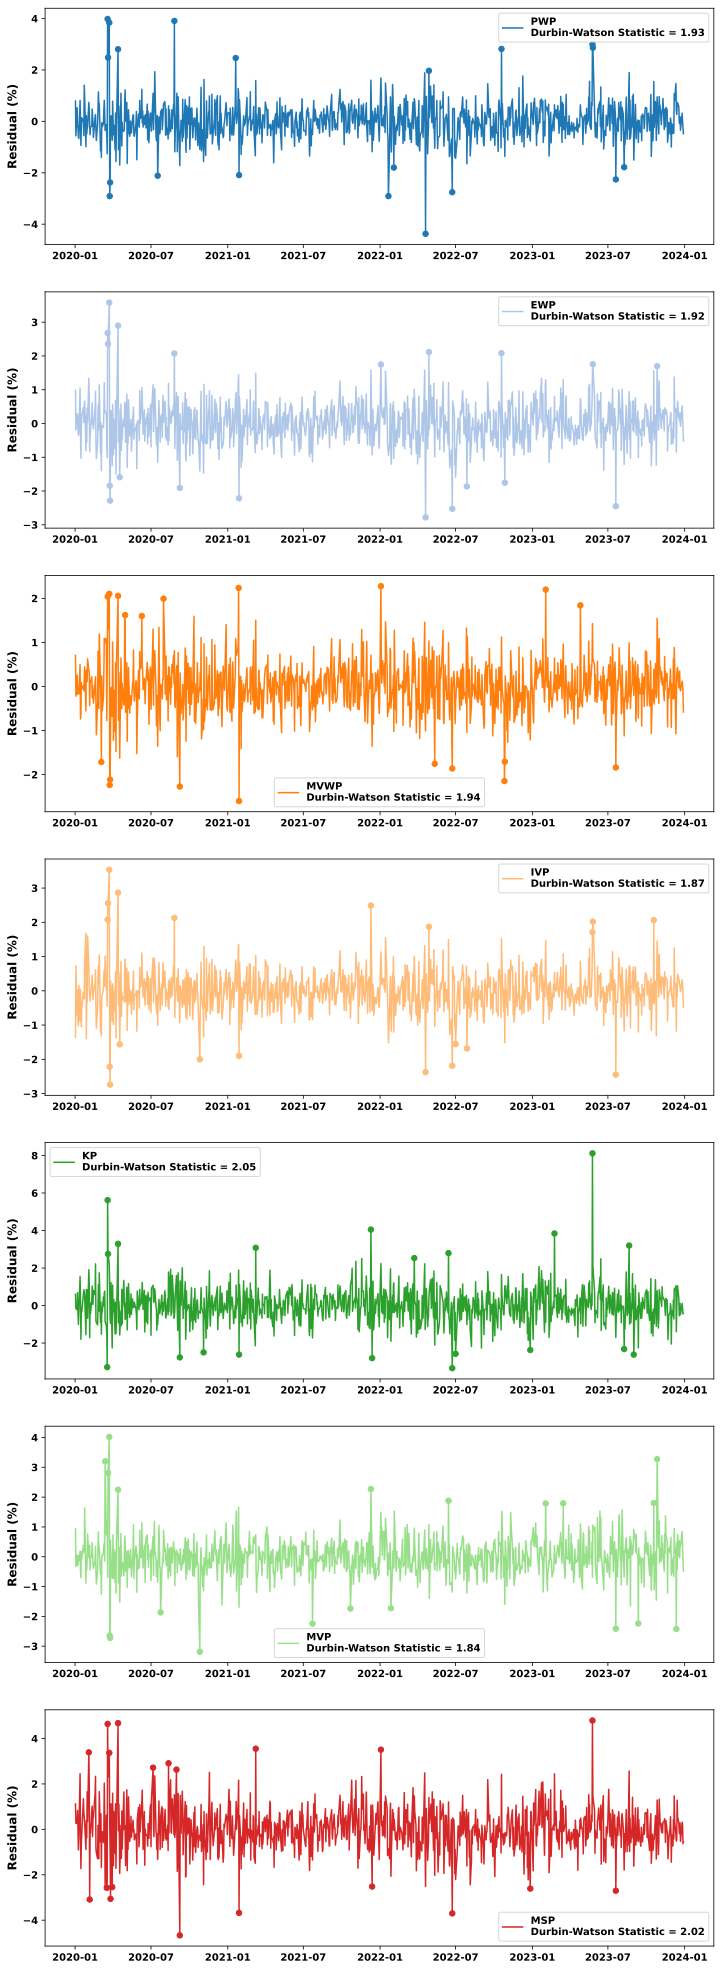

In [212]:
plot_residuals(returns[portfs], ff_returns[portfs])

In [213]:
def plot_residuals_vs_fitted(Y, Y_pred) :
    """
    Arguments :
    ---------
    - Y : DataFrame of actual daily returns 
    - Y_pred : DataFrame of daily returns predicted by French-Farma model 
    
    Returns :
    -------
    - None 
    
    Function :
    --------
    - Draws a scatter plot with predited daily returns on the x-axis and residuals on the y-axis for each asset 
    - Draws 2 horizontal lines for the 95% confidence interval of residual values for each asset 
    """
    residuals = Y - Y_pred 
    
    assets = Y.columns
    n_assets = len(assets)
    
    fig , ax = plt.subplots(nrows = n_assets, ncols = 1, figsize = (12, n_assets * 5), sharex = False, sharey = False)
    colors = sns.color_palette("tab20") 
    
    for i, asset in enumerate(assets) :
        ax[i].scatter(
            Y_pred[asset] * 100, 
            residuals[asset] * 100, 
            color = colors[i], 
            alpha = 0.7, s = 10, 
            label = asset
        )
        
        ax[i].axhline(y = 0, color = "black", linestyle = "--")
        ax[i].axhline(
            y = (residuals[asset].mean( ) - 2 * residuals[asset].std( )) * 100, 
            color = "red", 
            linestyle = "--", 
            label = "μ - 2σ (5%)"
        )
        ax[i].axhline(
            y = (residuals[asset].mean( ) + 2 * residuals[asset].std( )) * 100, 
            color = "green", 
            linestyle = "--", 
            label = "μ + 2σ (95%)"
        )
        
        ax[i].set_xlabel("Fitted Return (%)", fontsize = 12)
        ax[i].set_ylabel("Residual (%)", fontsize = 12)
        ax[i].legend( )
        
    plt.style.use("default")
    plt.show( )

In [214]:
plot_residuals_vs_fitted(returns[tickers], ff_returns[tickers])

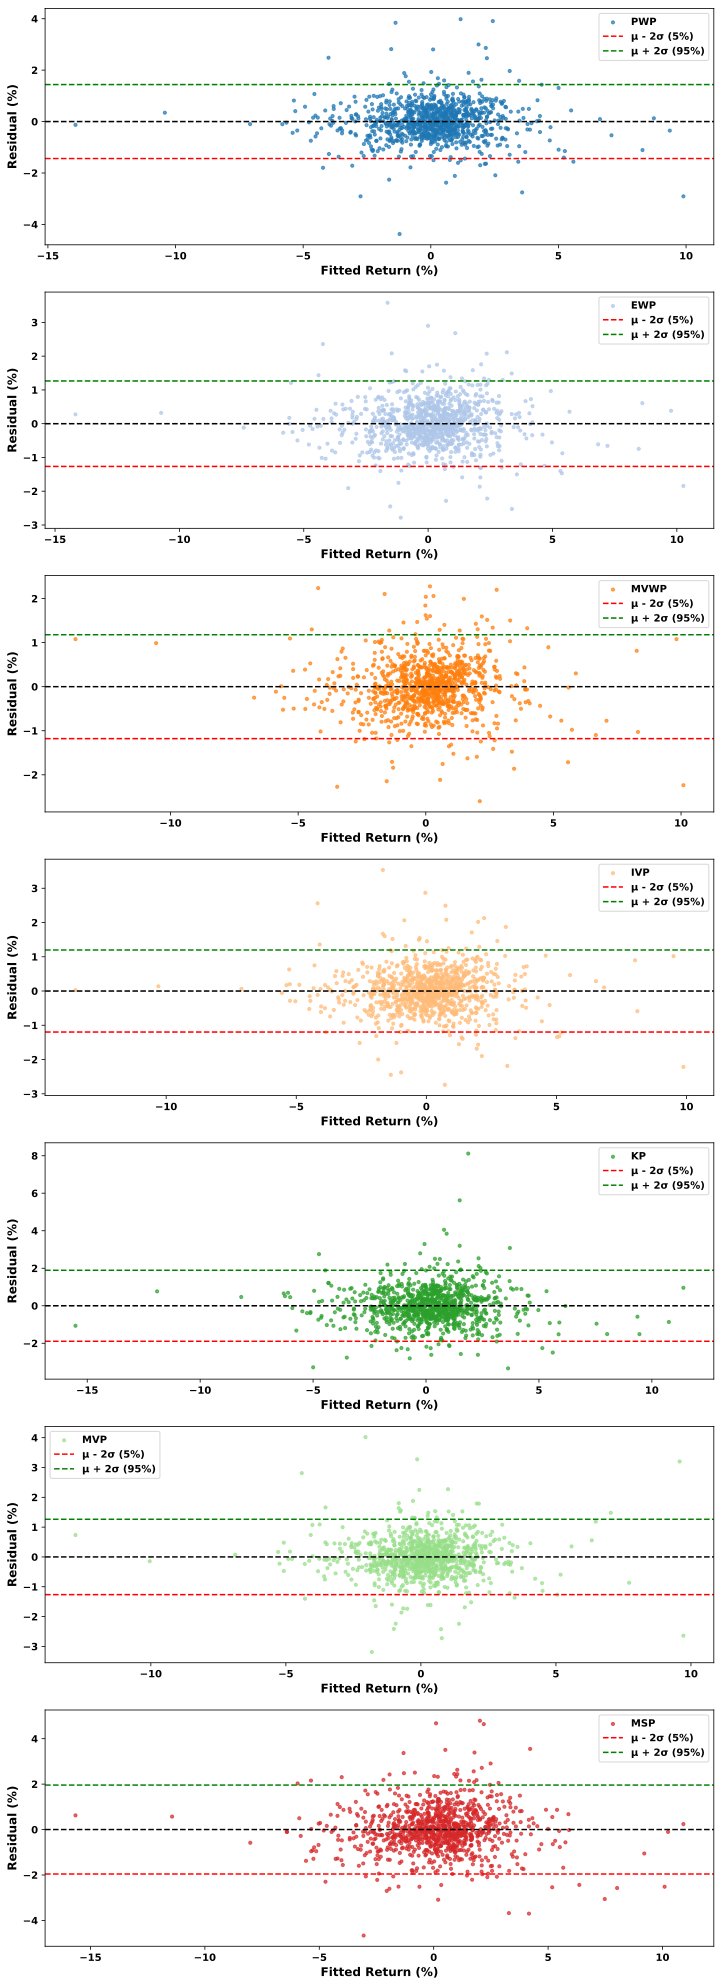

In [215]:
plot_residuals_vs_fitted(returns[portfs], ff_returns[portfs])

# Author 
[Khai Lap Vuong](https://www.linkedin.com/in/khai-lap-vuong/)